$Title$

    Predicting Knowledge Level Using User Knowledge Data

$Intro$

Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal


	We are using data collected on subjects who both prepared for and took an exam. The subjects prepared for and took two exams: one on prerequisite material, and one on targeted material whose knowledge built upon the prerequisite material. 
    
    
Clearly state the question you will try to answer with your project

	How high will somebody’s knowledge score be based on their study time, exam performance, and prerequisite knowledge? 
    
Identify and describe the dataset that will be used to answer the question


	We are using the User Knowledge Modeling Data Set. It includes columns for the degree of study time for both prerequisite knowledge and new knowledge bases, exam performances for both prerequisite knowledge and new knowledge bases, the degree of repetition, and the user’s knowledge level.
	All columns are recognized as type double except for the level of the user’s knowledge (which is a character variable). The data appears to be already normalized because all values (other than the user’s knowledge level) fit between values of 0 and 1. The data is very close to being tidy - other than a description of the data in an extra column, the literal data itself is tidy. 

$Preliminary  Data  Exploration$

New names:
* `` -> ...7
* `` -> ...8



targeted_study_time,repetition,prereq_study_time,prereq_exam_performance,targeted_exam_performance,understanding_level
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


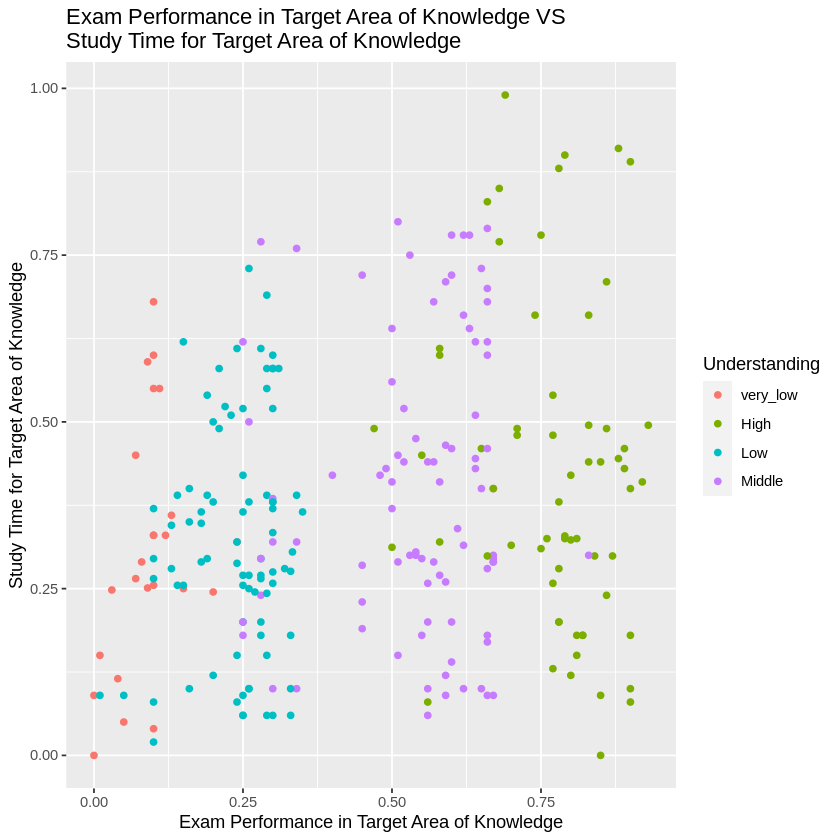

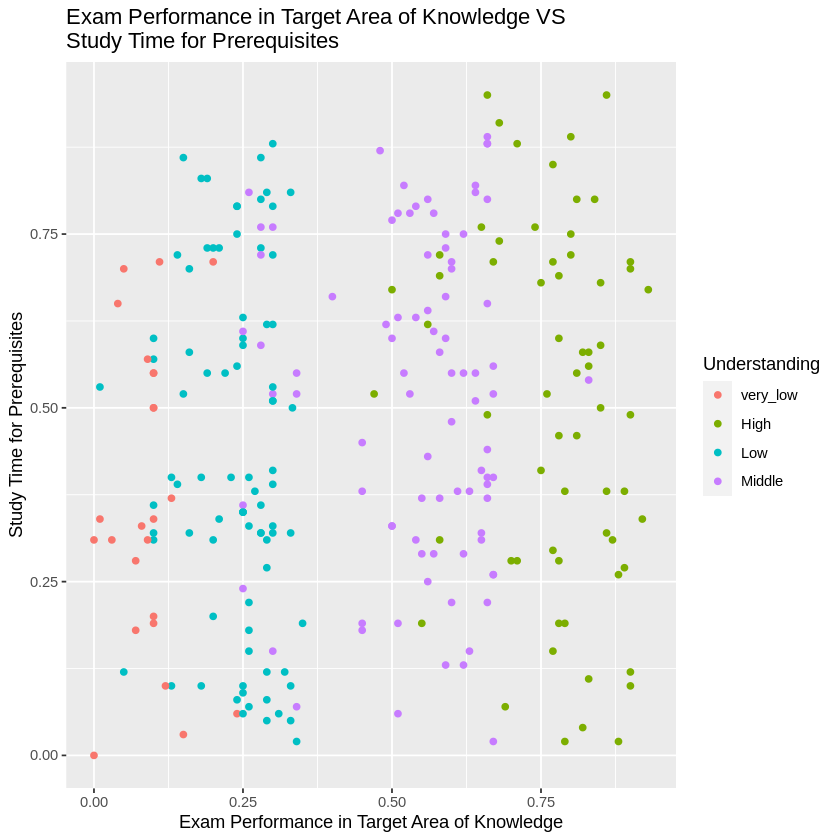

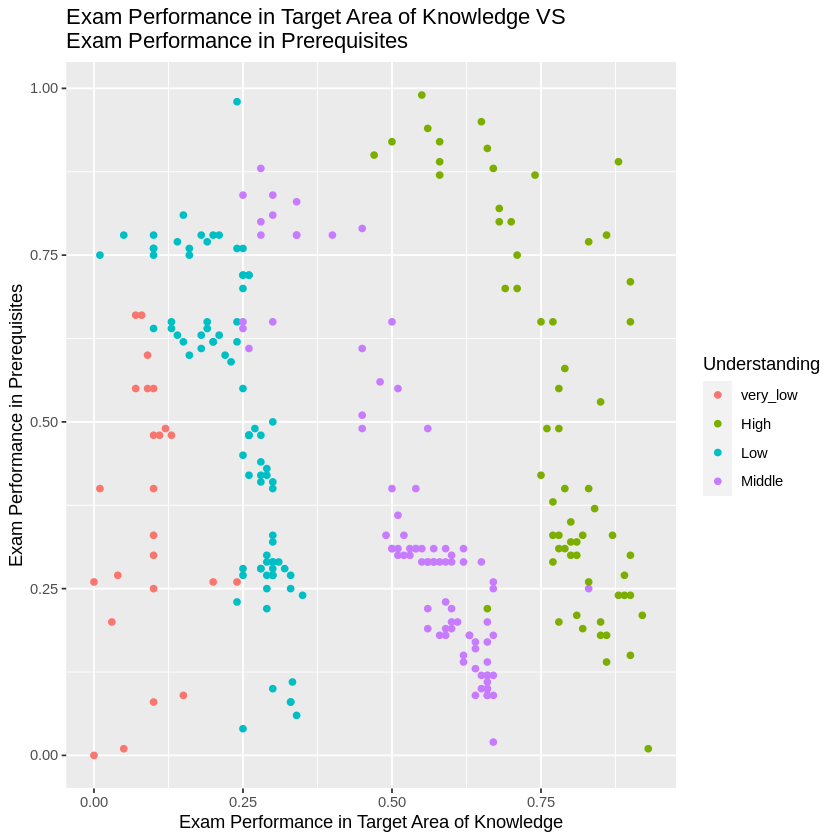

In [10]:
library(tidyverse)
library(repr)
library(readxl)

# 1. Demonstrate that the dataset can be read from the web into R.
# 2. Clean and wrangle your data into a tidy format.
# 3. Summarize data in a table


downloaded_data <- download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", 
                                "knowledge.xls")

user_knowledge_data <- read_excel("knowledge.xls", sheet = 2) %>%
    select(STG:UNS) %>%
    mutate(UNS = as_factor(UNS))

# user_knowledge_data <- read_excel("data/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet = 2) %>%
#     select(STG:UNS) %>%
#     mutate(UNS = as_factor(UNS))
colnames(user_knowledge_data) <- c("targeted_study_time", "repetition", "prereq_study_time", "prereq_exam_performance", "targeted_exam_performance", 
                         "understanding_level")
head(user_knowledge_data)

# 4. Visualize the data with at least one plot. 
target_exam_vs_target_study_time <- ggplot(user_knowledge_data, aes(x = targeted_exam_performance, 
                                                                    y = targeted_study_time, 
                                                                    colour = understanding_level)) +
    geom_point() +
    labs(x = "Exam Performance in Target Area of Knowledge", y = 
         "Study Time for Target Area of Knowledge", color = 
         "Understanding") +
    ggtitle("Exam Performance in Target Area of Knowledge VS \nStudy Time for Target Area of Knowledge") 
target_exam_vs_target_study_time

target_exam_vs_prereq_study_time <- ggplot(user_knowledge_data, aes(x = targeted_exam_performance, 
                                                                    y = prereq_study_time, 
                                                                    colour = understanding_level)) +
    geom_point() +
    labs(x = "Exam Performance in Target Area of Knowledge", 
         y = "Study Time for Prerequisites", 
         color = "Understanding") +
    ggtitle("Exam Performance in Target Area of Knowledge VS \nStudy Time for Prerequisites")
target_exam_vs_prereq_study_time

target_exam_vs_prereq_exam <- ggplot(user_knowledge_data, aes(x = targeted_exam_performance, 
                                                              y = prereq_exam_performance, 
                                                              colour = understanding_level)) +
    geom_point() +
    labs(x = "Exam Performance in Target Area of Knowledge", 
         y = "Exam Performance in Prerequisites", 
         color = "Understanding") +
    ggtitle("Exam Performance in Target Area of Knowledge VS \nExam Performance in Prerequisites")
target_exam_vs_prereq_exam


$Methods:$

Explain how you will conduct either your data analysis and which variables/columns you will use. 

	Load the tidyverse, tidymodels and readxl library.
    
	Initially, the file (which is an excel file) will be read using the read_excel() function in the library readxl.
    
	The file will be tidied by removing the columns with descriptions and blank values. 
    
	Then, all columns except for SCG (The degree of repetition number of users for goal object materials) will be selected using the select() function.
    
	Next, we will mutate the UNS (targeted_area_knowledge) column from a character variable to a factor variable to ensure it can be used to categorize points on a visualization using the mutate(column title, as_factor() ) argument.
    
	After that, we will rename the column names, since acronyms are not very descriptive. 
    
	Then, we will initially visualize the data using the ggplot() function with PEG (prereq_exam_performance) on the y-axis and LPR (targeted_exam_performance)
    
	To begin our classification, we’ll first pick our K by splitting our data into training and testing sets, and using cross validation.
    
    Then we’ll make our model with nearest_neighbours and our chosen K. 

	We need to create a recipe, specifying our predictors and scaling and centering our data.
    
	Then we’ll make a workflow, adding our model and recipe, and then fit our data inside.
    
	Finally, we will create our new observation and predict its category. 
    
    
Describe at least one way that you will visualize the results


	We will plot our new observation on a scatter plot comparing prerequisite and targeted exam performance and circle it. 


Expected outcomes and significance:


What do you expect to find?


	We expect to find that students with higher prerequisite knowledge and exam score will be classified as having a higher knowledge level.
    
    
What impact could such findings have?


	These findings could highlight the importance of having a solid foundation of basic knowledge prior to learning more complex materials, and describe how the amount of time studied influences one’s knowledge level. 
    
    
What future questions could this lead 


	What factors determine/influence exam performance?
    What other study methods, other than amount of time studied, can influence exam performance?